In [1]:
import os
import glob
import json
import xml.etree.ElementTree as ET

import cv2
import pandas
import openslide
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import chain
import matplotlib.pyplot as plt

from pyslide import slide, patching, Stitching
from pyslide.utilities import mask2rgb
from pyslide.preprocessing import calculate_weights, calculate_std_mean

### Annotations

Parse annotation files in formats:
- qupath
- imageJ
- ASAP
- csv

In [2]:
qupath_path='data/annotations/qupath_annotations.json'
asap_path='data/annotations/asap_annotations.xml'
imagej_path='data/annotations/imagej_annotations.xml'
json_path='data/annotations/json_annotations.json'
#csv_path='data/annotations/csv_annotations.csv'

In [3]:
annotate_qupath=slide.Annotations([qupath_path],source="qupath")
annotate_imagej=slide.Annotations([imagej_path],source="imagej")
annotate_asap=slide.Annotations([asap_path],source="asap")
#annotate_csv=slide.Annotations([csv_path],source="csv")

In [4]:
annotate_qupath

    classes  number
0  Negative       4
1     Other       3

In [5]:
annotate_imagej

           classes  number
0                        1
1            SINUS      55
2          ADIPOSE       3
3  GERMINAL CENTRE      27
4         FOLLICLE      29

In [6]:
annotate_asap

      classes  number
0  metastases      20
1        None       1

Convert annotations to csv file or Pandas Dataframe

In [7]:
annotate_qupath.df()

,labels,x,y
0,Negative,73993,23888
1,Negative,73925,23895
2,Negative,73859,23914
3,Negative,73836,23926
4,Negative,73831,23928
...,...,...,...
139,Negative,74239,23889
140,Negative,74217,23888
141,Negative,73993,23888
142,Other,77875,23260


In [8]:
annotate_imagej.df()

,labels,x,y
0,,16527,9382
1,,65373,9382
2,,65373,30671
3,,16527,30671
4,SINUS,41981,11394
...,...,...,...
1917,FOLLICLE,21043,24756
1918,FOLLICLE,21010,24739
1919,FOLLICLE,20976,24722
1920,FOLLICLE,20959,24722


In [9]:
annotate_qupath.save('test.csv')

### Slide class

Pass wsi-path and annotation object to slide class. Following functions:
- Generate slide mask
- Crop a region
- Detect sections

In [34]:
QUPATH_PATH='/Users/w2030634/Projects/PySlide/data/annotations/2865 B2 LN.json'
WSI_PATH='data/wsi/2865 B2 LN.ndpi'

In [38]:
annotate=slide.Annotations([QUPATH_PATH],source="qupath",labels=['sinus','follicle','germinal centre'])
wsi=slide.Slide(WSI_PATH,mag=0,annotations=annotate)
mask=wsi.slide_mask
print('border:{}'.format(wsi.get_border()))

border:[(3981.0, 118531.0), (11202.0, 92659.0)]


(-0.5, 1999.5, 1999.5, -0.5)

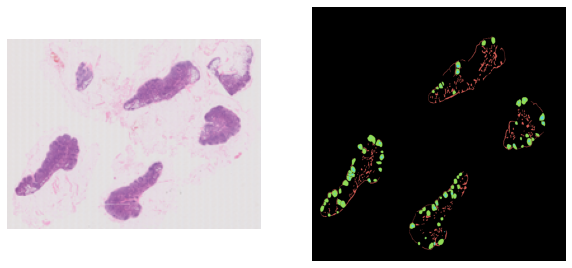

In [46]:
slide_thumbnail=np.array(wsi.get_thumbnail((200,200)))
mask=wsi.slide_mask
fig,axes=plt.subplots(1,2,figsize=(10,10))
axes[0].imshow(slide_thumbnail)
axes[0].axis('off')
axes[1].imshow(mask)
axes[1].axis('off')

#### Resize border 

In [47]:
print('border:{}'.format(wsi.get_border()))
borders=wsi.get_border()
x_new=wsi.resize_border(borders[0][0],factor=32)

border:[(3981.0, 118531.0), (11202.0, 92659.0)]


#### Detect components

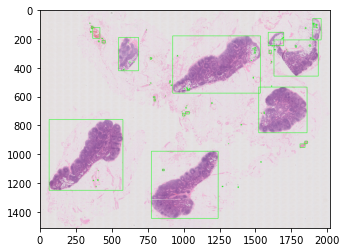

In [48]:
img,borders=wsi.detect_components()
plt.imshow(img[-1])

#### Generate region

In [49]:
wsi.dimensions
border=borders[14]
(x1,x2),(y1,y2)=border
border

[(4032, 36864), (48576, 17152)]

In [ ]:
wsi2=openslide.OpenSlide(WSI_PATH)
region=wsi2.read_region((4032,48576),3,(50000,50000))
region_new=cv2.resize(np.array(region.convert('RGB')),(250,250))
plt.imshow(region_new)

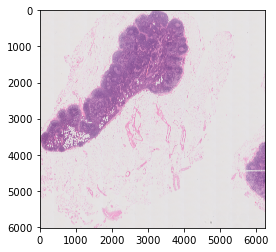

In [10]:
region=wsi.generate_region(mag=3,x=(x1,x2),y=(y1,y2),x_size=50000,y_size=50000)
plt.imshow(region[0])

## Patching

In [4]:
patch=patching.Patching(wsi,mag_level=3,step=1024,size=(1024,1024))
#patch.save('images',mask_flag=True)

num patches: 140


### filter patches

Num removed: 73
Remaining:23


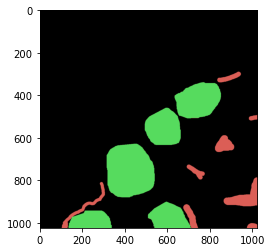

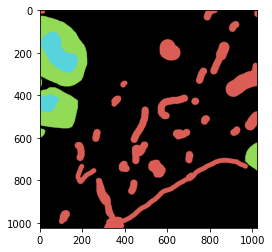

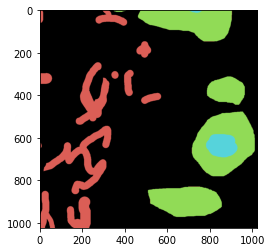

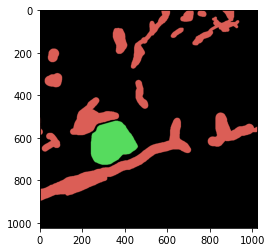

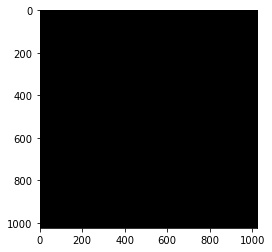

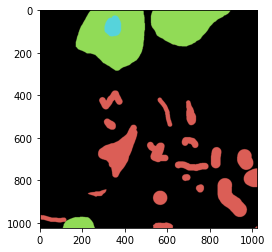

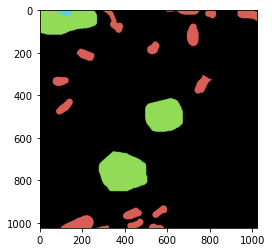

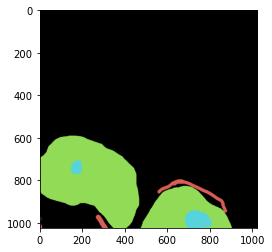

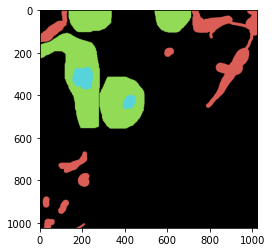

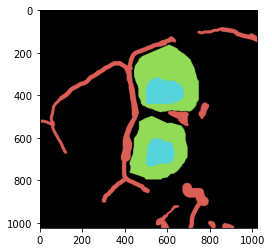

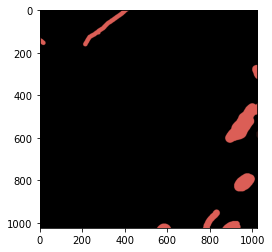

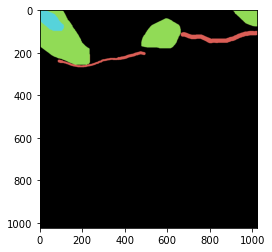

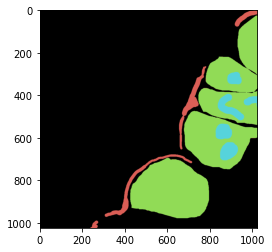

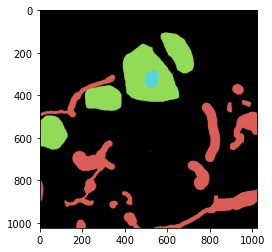

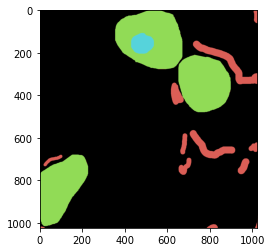

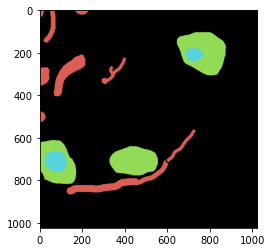

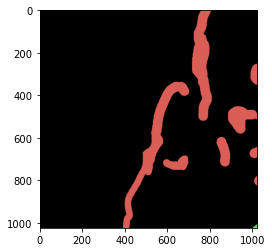

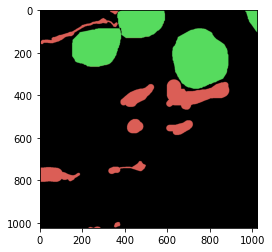

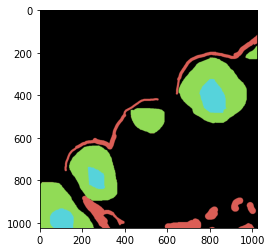

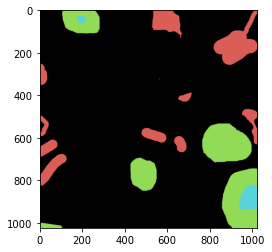

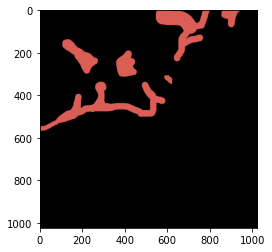

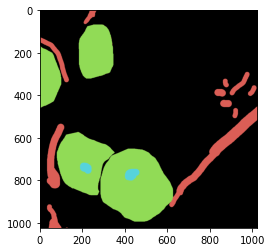

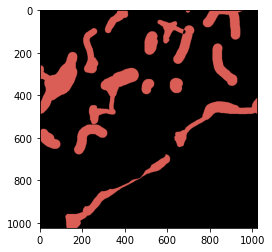

In [12]:
patch.filter_patches(210)
patch.save('images',mask_flag=True)
masks=glob.glob('images/masks/*')
for m in masks:
    mask=cv2.imread(m)
    mask=mask2rgb(mask[:,:,0])
    plt.imshow(mask)
    plt.show()

### Get labels

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 1, 2]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2]
[0]
[0]
[0]
[0]
[0]
[0, 1, 2]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 1, 2, 3]
[0, 1]
[0]
[0]
[0, 1, 2]
[0, 1]
[0]
[0]
[0]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2, 3]
[0]
[0, 1]
[0, 1, 2, 3]
[0, 1]
[0]
[0]
[0]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0]
[0, 1, 2, 3]
[0, 1, 2]
[0]
[0]
[0]
[0, 1, 2]
[0, 1, 2, 3]
[0, 1]
[0]
[0, 1]
[0, 1]
[0, 1]
[0]
[0]
[0]
[0, 1]
[0, 1]
[0]
[0]
[0, 1, 2]
[0, 1]
[0, 1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 1]
[0, 1]
[0]
[0, 1]
[0, 1, 2]
[0, 1, 2, 3]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2]
[0]
[0]
[0]
[0]


<AxesSubplot:>

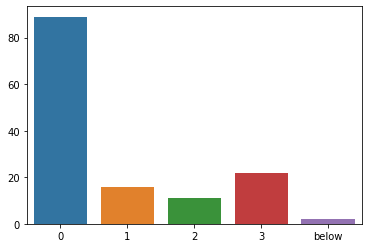

In [5]:
patch.generate_labels(0.5)
patch.plotlabeldist()

### Stitching

In [6]:
stitch=Stitching('images/images',name='2865 B2 LN.ndpi',mag_level=3)
canvas=stitch.stitch(size=(2500,2500))

{'name': '2865 B2 LN.ndpi', 'mag': 3, 'step': 1024, 'border': [[3981, 110477], [11202, 84930]], 'patches': 140}


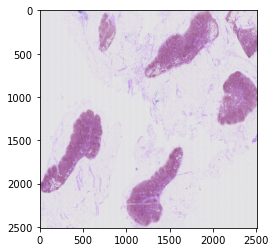

In [7]:
plt.imshow(canvas)

## Preprocessing 

In [4]:
calculate_weights(mask_path='images/masks',num_cls=4)

[1.1850617226198867,
 16.962905236030736,
 11.232883500960867,
 122.16584436767403]

In [2]:
calculate_std_mean('images/images')

[0. 0. 0.]
total number pixels: 24117248
mean: [0.74730681 0.59215717 0.75368948], std: [0.12720346 0.21965498 0.15878633]


(array([0.74730681, 0.59215717, 0.75368948]),
 array([0.12720346, 0.21965498, 0.15878633]))

### Missing

In [ ]:
image=np.array(wsi.get_thumbnail((1000,1000)))
plt.imshow(image)
plt.show()
hist1 = cv2.calcHist([image],[0],None,[256],[0,256])
hist2 = cv2.calcHist([image],[1],None,[256],[0,256])
hist3 = cv2.calcHist([image],[2],None,[256],[0,256])
plt.subplot(222), plt.plot(hist1), plt.plot(hist2),plt.plot(hist3)